In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# SWIFT Perturbation Methods Study 2013-11-08 CBL comparison: 
# Data analysis (template)

******
##  <font color='darkred'>User Settings:</font>
Simulation name and directory, and name of virtual towers

In [2]:
# Are you using wrfouts ('wrfout') or tslist output ('ts')?
model_data_type = 'wrfout' 

# Where is the run directory located?
modeldatapath = '/glade/work/hawbecke/MMC/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/'
#modeldatapath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/NoPert_CBL_18z-20z/'

# Where should the processed data be saved?
#modelprocessedpath = '/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/'
modelprocessedpath = modeldatapath
save_figs = False

# Should we compare to observations?
compare_to_obs = True
# Observation directory location:
TTUdata = '/glade/u/home/hawbecke/Research/MMC/Observations/TTU_tilt_corrected_20131108-09.csv'

---
####  <font color='darkred'>End User Settings</font>
---

In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import interpolate
from netCDF4 import Dataset
#import wrf as wrfpy

from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn import linear_model
import time

In [4]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
#sys.path.append('../../../')
module_path = os.path.join(os.environ['HOME'],'Code/Python')
if module_path not in sys.path:
    sys.path.append(module_path)

from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, theta, model4D_calcQOIs, model4D_spatial_spectra, model4D_spatial_cospectra, model4D_spatial_pdfs
from mmctools.helper_functions import model4D_spectra, model4D_cospectra, model4D_pdfs, reference_lines
from mmctools.wrf.utils import wrfout_seriesReader, tsout_seriesReader, combine_towers

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

In [6]:
#JAS grabbed the following code from stack-overflow post
#https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook/49199019#49199019
# to list package versions used in this notebook...
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xarray==0.13.0
scipy==1.3.1
scikit-learn==0.21.3
pandas==0.25.1
numpy==1.17.2
netCDF4==1.4.2
matplotlib==3.1.1


In [6]:
# If using wrfout data:
if model_data_type == 'wrfout':
    # Specify which wrfout files to use:
    modeldatafilter = 'wrfout_d02_2013-11-08_[12][89]:[0-5][0-9]:00'
    spectra_dim='ny'
    average_dim='datetime'
    modelprocessedfile = 'wrfout.nc'
    iLocs=[25,40,120,240,300,360,420,480,540,700,900] # downstream locations from which to assess turbulence characteristics versus fetch
    
# If using tslist output:
elif model_data_type == 'ts':
    # specify: the names of restart directories (restarts), 
    #          the start time of the simulation (restart_start),
    #          and the domain of interest.
    restarts = ['tsout_1800_1830','tsout_1830_1900','tsout_1900_1930','tsout_1930_2000']
    restart_start = '2013-11-08 14:00'
    domain_of_interest = 'd02'   
    spectra_dim='datetime'
    average_dim='ny'
    modelprocessedfile = 'tsout.nc'
    iLocs = np.linspace(0,19,20).astype(int) # downstream locations from which to assess turbulence characteristics versus fetch

levels=[5,10,15,30,40]

# Names of output files

In [7]:
simname='PMIC-1_{}'.format(model_data_type)

modelprocessedname = '{:s}{:s}.nc'.format(modelprocessedpath,simname)

modelprocessedfigure  = 'Microscale_{}_AssessmentMontage120minutes.png'.format(model_data_type)
modelprocessedfetch   = 'Microscale_{}_AssessmentFetch120minutes.png'.format(model_data_type)
modelprocessedobscomp = 'Microscale_{}_AssessmentObsComparison.png'.format(model_data_type)

output_figure  = os.path.join(modelprocessedpath,modelprocessedfigure)
output_fetch   = os.path.join(modelprocessedpath,modelprocessedfetch)
output_obscomp = os.path.join(modelprocessedpath,modelprocessedobscomp)
output_spectra = os.path.join(modelprocessedpath,simname+'_spectra.nc')
output_stats   = os.path.join(modelprocessedpath,simname+'_stats.nc')

# Part 1: Load, process 4-D data

### 1a. Model-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized xarrays DataSet:**</font></font>

- with dimensions `datetime`,`nz`,`ny`,`nx`
- with coordinate variables `*datetime`,`x`,`y`,`z`,`zsurface`,`lat`,`lon`
- standard column names `u`, `v`, `w`, `theta`,`p`,`wspd`,`wdir`
- standard SI units of [m], [m/s], and [K]

### 1b. If necessary construct Dataset from raw model outputs

In [8]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, establishing reference to processed-dataset directly...'.format(modelprocessedname))
    ds=xr.open_mfdataset(modelprocessedname,concat_dim='datetime',combine='nested',chunks={'nz': 11})
    #CPU times: user 19.7 ms, sys: 1.64 ms, total: 21.4 ms
    #Wall time: 21.4 ms     ### JAS note: this is fast because nothing is actually read or loaded into memory (lazy evaluation)
else:
    if model_data_type == 'wrfout':
        print('{:s} does not exist, reading 4-d model outputs and destaggering from wrfout(s)...'.format(modelprocessedname))
        ds = wrfout_seriesReader(modeldatapath,modeldatafilter,specified_heights=None)
    elif model_data_type == 'ts':
        print('{:s} does not exist, reading tslist outputs...'.format(modelprocessedname))
        ds = tsout_seriesReader(modeldatapath, restarts, restart_start, domain_of_interest='d02')
    #%time ds = wrfout_seriesReader(modeldatapath,modeldatafilter,specified_heights=[4.0, 8.0, 12.0, 20.0, 40.0, 60.0, 80.0, 100.0, 150.0, 200.0])
    #CPU times: user 6min 6s, sys: 5min, total: 11min 6s
    #Wall time: 13min 4s   ###JAS this was for 60 time instances

/glade/work/hawbecke/MMC/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout.nc exists, establishing reference to processed-dataset directly...


## 2. Data processing

### 2a. Calculation of spanwise mean and perturbations for all streamwise locations and all variables of interest

In [9]:
if os.path.exists(modelprocessedname):
    print('{:s} exists, skipping calculation of quantities of interest...'.format(modelprocessedname))
else:
    print('{:s} does not exist, calculating of quantities of interest...'.format(modelprocessedname))
    if model_data_type == 'wrfout':
        ds=model4D_calcQOIs(ds,'ny',data_type=model_data_type)
    elif model_data_type == 'ts':
        ds=model4D_calcQOIs(ds,'datetime',data_type=model_data_type,mean_opt='lowess',lowess_delta=18000.0)
    #CPU times: user 3min 3s, sys: 8min 20s, total: 11min 24s
    #Wall time: 17min 37s ###JAS this was for 60 time instances
    print(ds)

/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout.nc exists, skipping calculation of quantities of interest...


### Figure to check the mean:
If you are interested in seeing how the means look, change this block to 'code'

    #%%time
    fig,ax = plt.subplots(nrows=4,figsize=(16,12),sharex=True)
    print('starting...')
    ds.u.isel(nz=15,ny=5,nx=14).plot(ax=ax[0],lw=2.0,c='k',alpha=0.5)
    ds.uMean.isel(nz=15,ny=5,nx=14).plot(ax=ax[0],lw=3.0,c='blue')
    ax[0].plot(ds.datetime,np.ones(ds.datetime.size)*np.mean(ds.u.isel(nz=15,ny=5,nx=14).data),c='darkred',lw=2.0)
    ax[0].set_xlabel('')
    print('1 done')
    ds.isel(nz=15,ny=5,nx=14).v.plot(ax=ax[1],lw=2.0,c='k',alpha=0.5)
    ds.isel(nz=15,ny=5,nx=14).vMean.plot(ax=ax[1],lw=2.0,c='blue')
    ax[1].plot(ds.datetime,np.ones(ds.datetime.size)*np.mean(ds.v.isel(nz=15,ny=5,nx=14).data),c='darkred',lw=2.0)
    ax[1].set_xlabel('')
    print('2 done')
    ds.isel(nz=15,ny=5,nx=14).w.plot(ax=ax[2],lw=2.0,c='k',alpha=0.5)
    ds.isel(nz=15,ny=5,nx=14).wMean.plot(ax=ax[2],lw=2.0,c='blue')
    ax[2].plot(ds.datetime,np.ones(ds.datetime.size)*np.mean(ds.w.isel(nz=15,ny=5,nx=14).data),c='darkred',lw=2.0)
    ax[2].set_xlabel('')
    print('3 done')
    ds.isel(nz=15,ny=5,nx=14).theta.plot(ax=ax[3],lw=2.0,c='k',alpha=0.5)
    ds.isel(nz=15,ny=5,nx=14).thetaMean.plot(ax=ax[3],lw=2.0,c='blue')
    ax[3].plot(ds.datetime,np.ones(ds.datetime.size)*np.mean(ds.theta.isel(nz=15,ny=5,nx=14).data),c='darkred',lw=2.0)


### 2b. Save full processed dataset, if desired

In [10]:
saveProcessedDataSetSwitch=True

if os.path.exists(modelprocessedname):
    print('{:s} exists, no need to save...'.format(modelprocessedname))
else:
    if saveProcessedDataSetSwitch:
        ds.to_netcdf(modelprocessedname, mode='w', format='NETCDF4', unlimited_dims='datetime', compute=True)
        #CPU times: user 1.34 s, sys: 1min 48s, total: 1min 50s
        #Wall time: 5min 23s

/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout.nc exists, no need to save...


# Check to see if spectra / cospectra / PDF have already been calculated:

In [11]:
if os.path.exists(output_spectra):
    print('{:s} exists, no need to calculate spectra / cospectra...'.format(output_spectra))
    calc_spectra = False
    spectra_ds=xr.open_dataset(output_spectra)
else:
    print("doesn't exist... going to calculate spectra and cospectra...")
    calc_spectra = True
    
if os.path.exists(output_stats):
    print('{:s} exists, no need to calculate PDF...'.format(output_stats))
    calc_stats = False
    stats_ds=xr.open_dataset(output_stats)
else:
    print("doesn't exist... going to calculate spectra and cospectra...")
    calc_stats = True
        

/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout_spectra.nc exists, no need to calculate spectra / cospectra...
/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout_stats.nc exists, no need to calculate PDF...


# Calculate windspeed-based spectra

#### For tslist output this can take around 30 minutes per level.

In [12]:
#%%time
if calc_spectra:
    vertLevels=[15]
    fld='wspd' #'theta'
    fldMean='UMean' #'thetaMean'
    print('calculating spectra of {}'.format(fld))
    f, Puuf = model4D_spectra(ds,spectra_dim=spectra_dim,average_dim=average_dim,
                              vert_levels=vertLevels,horizontal_locs=iLocs,
                              fld=fld,fldMean=fldMean)

    ##Past-timing
    #CPU times: user 2 s, sys: 1.32 s, total: 3.31 s
    #Wall time: 17.9 s
    ##New-timing: From 60-time instance reload of the full procesed datafile
    #CPU times: user 1.49 s, sys: 184 ms, total: 1.67 s
    #Wall time: 4.42 s
else:
    print('spectra already calculated...')

spectra already calculated...


# Calculate cospectra

In [13]:
#%%time
if calc_spectra:
    vertLevels=[15]
    fld0 = 'wspd'; fld0Mean = 'UMean' 
    fld1 = 'w'; fld1Mean = 'wMean' 
    print('calculating cospectra of {} and {}'.format(fld0,fld1))
    f, Puwf = model4D_cospectra(ds,spectra_dim=spectra_dim,average_dim=average_dim,
                                vert_levels=vertLevels,horizontal_locs=iLocs,
                                fldv0=fld0,fldv0Mean=fld0Mean,fldv1=fld1,fldv1Mean=fld1Mean)

    fld0 = 'w'; fld0Mean = 'wMean'
    fld1 = 'theta'; fld1Mean = 'thetaMean'
    print('calculating cospectra of {} and {}'.format(fld0,fld1))
    f, Pwtf = model4D_cospectra(ds,spectra_dim=spectra_dim,average_dim=average_dim,
                                vert_levels=vertLevels,horizontal_locs=iLocs,
                                fldv0=fld0,fldv0Mean=fld0Mean,fldv1=fld1,fldv1Mean=fld1Mean)
else:
    print('cospectra already calculated...')

cospectra already calculated...


# Calculate w-perturbation distribution and distribution higher-order moments

In [14]:
#%%time
#from scipy.stats import skew,kurtosis
if calc_stats:
    bins_vector = np.linspace(-5.0,5.0,240)
    fld='w' #'theta'
    fldMean='wMean' #'thetaMean'
    print('Calculating PDF of {}'.format(fld))
    hist_cum, bin_edges, sk_vec, kurt_vec = model4D_pdfs(ds,'ny',vertLevels,iLocs,fld,fldMean,bins_vector)

    ##Past-timing
    #CPU times: user 1min 42s, sys: 2min 16s, total: 3min 59s
    #Wall time: 8min 3s
    ##New-timing: From 60-time instance reload of the full procesed datafile
    #CPU times: user 37.6 s, sys: 1min 54s, total: 2min 31s
    #Wall time: 2min 44s
    ##Newest-timing: From 120-time instance reload of the full procesed datafile
    #Accumulating statistics over 120 time-instances
    #CPU times: user 8.8 s, sys: 2.35 s, total: 11.1 s
    #Wall time: 19.6 s
else:
    print('stats already calculated...')

stats already calculated...


# Create xarray datasets for the spectra and distrbution metrics, then save them to file for sharing amongst the group

In [15]:
if calc_spectra: spectra_ds = xr.Dataset()
if calc_stats: stats_ds = xr.Dataset()

In [16]:
if calc_spectra:
    spectra_dims_dict = {
            'dim_0':'vert_levels',
            'dim_1':'x',
            'dim_2': 'f',
    }
    spectra_ds['Puuf'] = xr.DataArray(Puuf)
    spectra_ds['Puwf'] = xr.DataArray(Puwf)
    spectra_ds['f'] = xr.DataArray(np.squeeze(f),dims=['dim_2'])
    spectra_ds = spectra_ds.assign_coords(f=spectra_ds['f'])
    spectra_ds = spectra_ds.assign_coords(f=spectra_ds['f'])
    spectra_ds = spectra_ds.rename_dims(spectra_dims_dict)   
    spectra_ds.attrs['vert_level'] = vertLevels[0]
    spectra_ds['iLocs'] = xr.DataArray(iLocs,dims=['x'])

if calc_stats:
    stats_dims_dict = {
            'dim_0':'vert_levels',
            'dim_1':'x',
            'dim_2': 'bins',
    }
    stats_ds['hist_cum']=xr.DataArray(hist_cum)
    stats_ds['bins']=xr.DataArray(bins_vector[:-1]+np.diff(bins_vector)/2.0,dims=['dim_2'])
    stats_ds['sk_vec']=xr.DataArray(sk_vec,dims=['dim_0','dim_1'])
    stats_ds['kurt_vec']=xr.DataArray(kurt_vec,dims=['dim_0','dim_1'])
    stats_ds = stats_ds.assign_coords(bins=stats_ds['bins'])
    stats_ds.attrs['vert_level'] = vertLevels[0]
    stats_ds['iLocs'] = xr.DataArray(iLocs,dims=['x'])
    
    if model_data_type == 'wrfout':
        stats_ds = stats_ds.assign_coords(x=ds['x'].isel(nx=iLocs).values)
    elif model_data_type == 'ts':
        stats_ds = stats_ds.assign_coords(x=ds['x'].isel(nx=iLocs,ny=0).values)
    stats_ds = stats_ds.rename_dims(stats_dims_dict)
print(spectra_ds)
print(stats_ds)

<xarray.Dataset>
Dimensions:  (f: 240, vert_levels: 1, x: 11)
Coordinates:
  * f        (f) float64 0.0 0.0001736 0.0003472 ... 0.04115 0.04132 0.04149
Dimensions without coordinates: vert_levels, x
Data variables:
    Puuf     (vert_levels, x, f) float64 ...
    Puwf     (vert_levels, x, f) float64 ...
    iLocs    (x) int64 ...
Attributes:
    vert_level:  15
<xarray.Dataset>
Dimensions:   (bins: 239, vert_levels: 1, x: 11)
Coordinates:
  * x         (x) float64 306.0 486.0 1.446e+03 ... 8.406e+03 1.081e+04
  * bins      (bins) float64 -4.979 -4.937 -4.895 -4.854 ... 4.895 4.937 4.979
Dimensions without coordinates: vert_levels
Data variables:
    hist_cum  (vert_levels, x, bins) float64 ...
    sk_vec    (vert_levels, x) float64 ...
    kurt_vec  (vert_levels, x) float64 ...
    iLocs     (x) int64 ...
Attributes:
    vert_level:  15


In [17]:
if calc_spectra: spectra_ds.to_netcdf(output_spectra, mode='w', format='NETCDF4', compute=True)
print(output_spectra)
if calc_stats: stats_ds.to_netcdf(output_stats, mode='w', format='NETCDF4', compute=True)
print(output_stats)

/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout_spectra.nc
/glade/scratch/hawbecke/WRF/SWiFT_20131108_PertMethodsGroup/TPert_CBL_18z-20z/PMIC-1_wrfout_stats.nc


# Create montage simulation summary figure of instantaneous windspeed, windspeed energy spectra, cospectra, and w-perturbation distributions

[ 25  40 120 240 300 360 420 480 540 700 900]
ax[0] setup complete...
ax[1] setup complete...
ax[2] setup complete...
ax[3] setup complete...
ax[4] setup complete...
ax[5] setup complete...
ax[6] setup complete...
ax[7] setup complete...
ax[8] setup complete...
ax[9] setup complete...
ax[10] setup complete...
0 30
ax[11] setup complete...
ax[12] setup complete...
ax[13] setup complete...
ax[14] setup complete...
41 45 0 15
ax[15] setup complete...


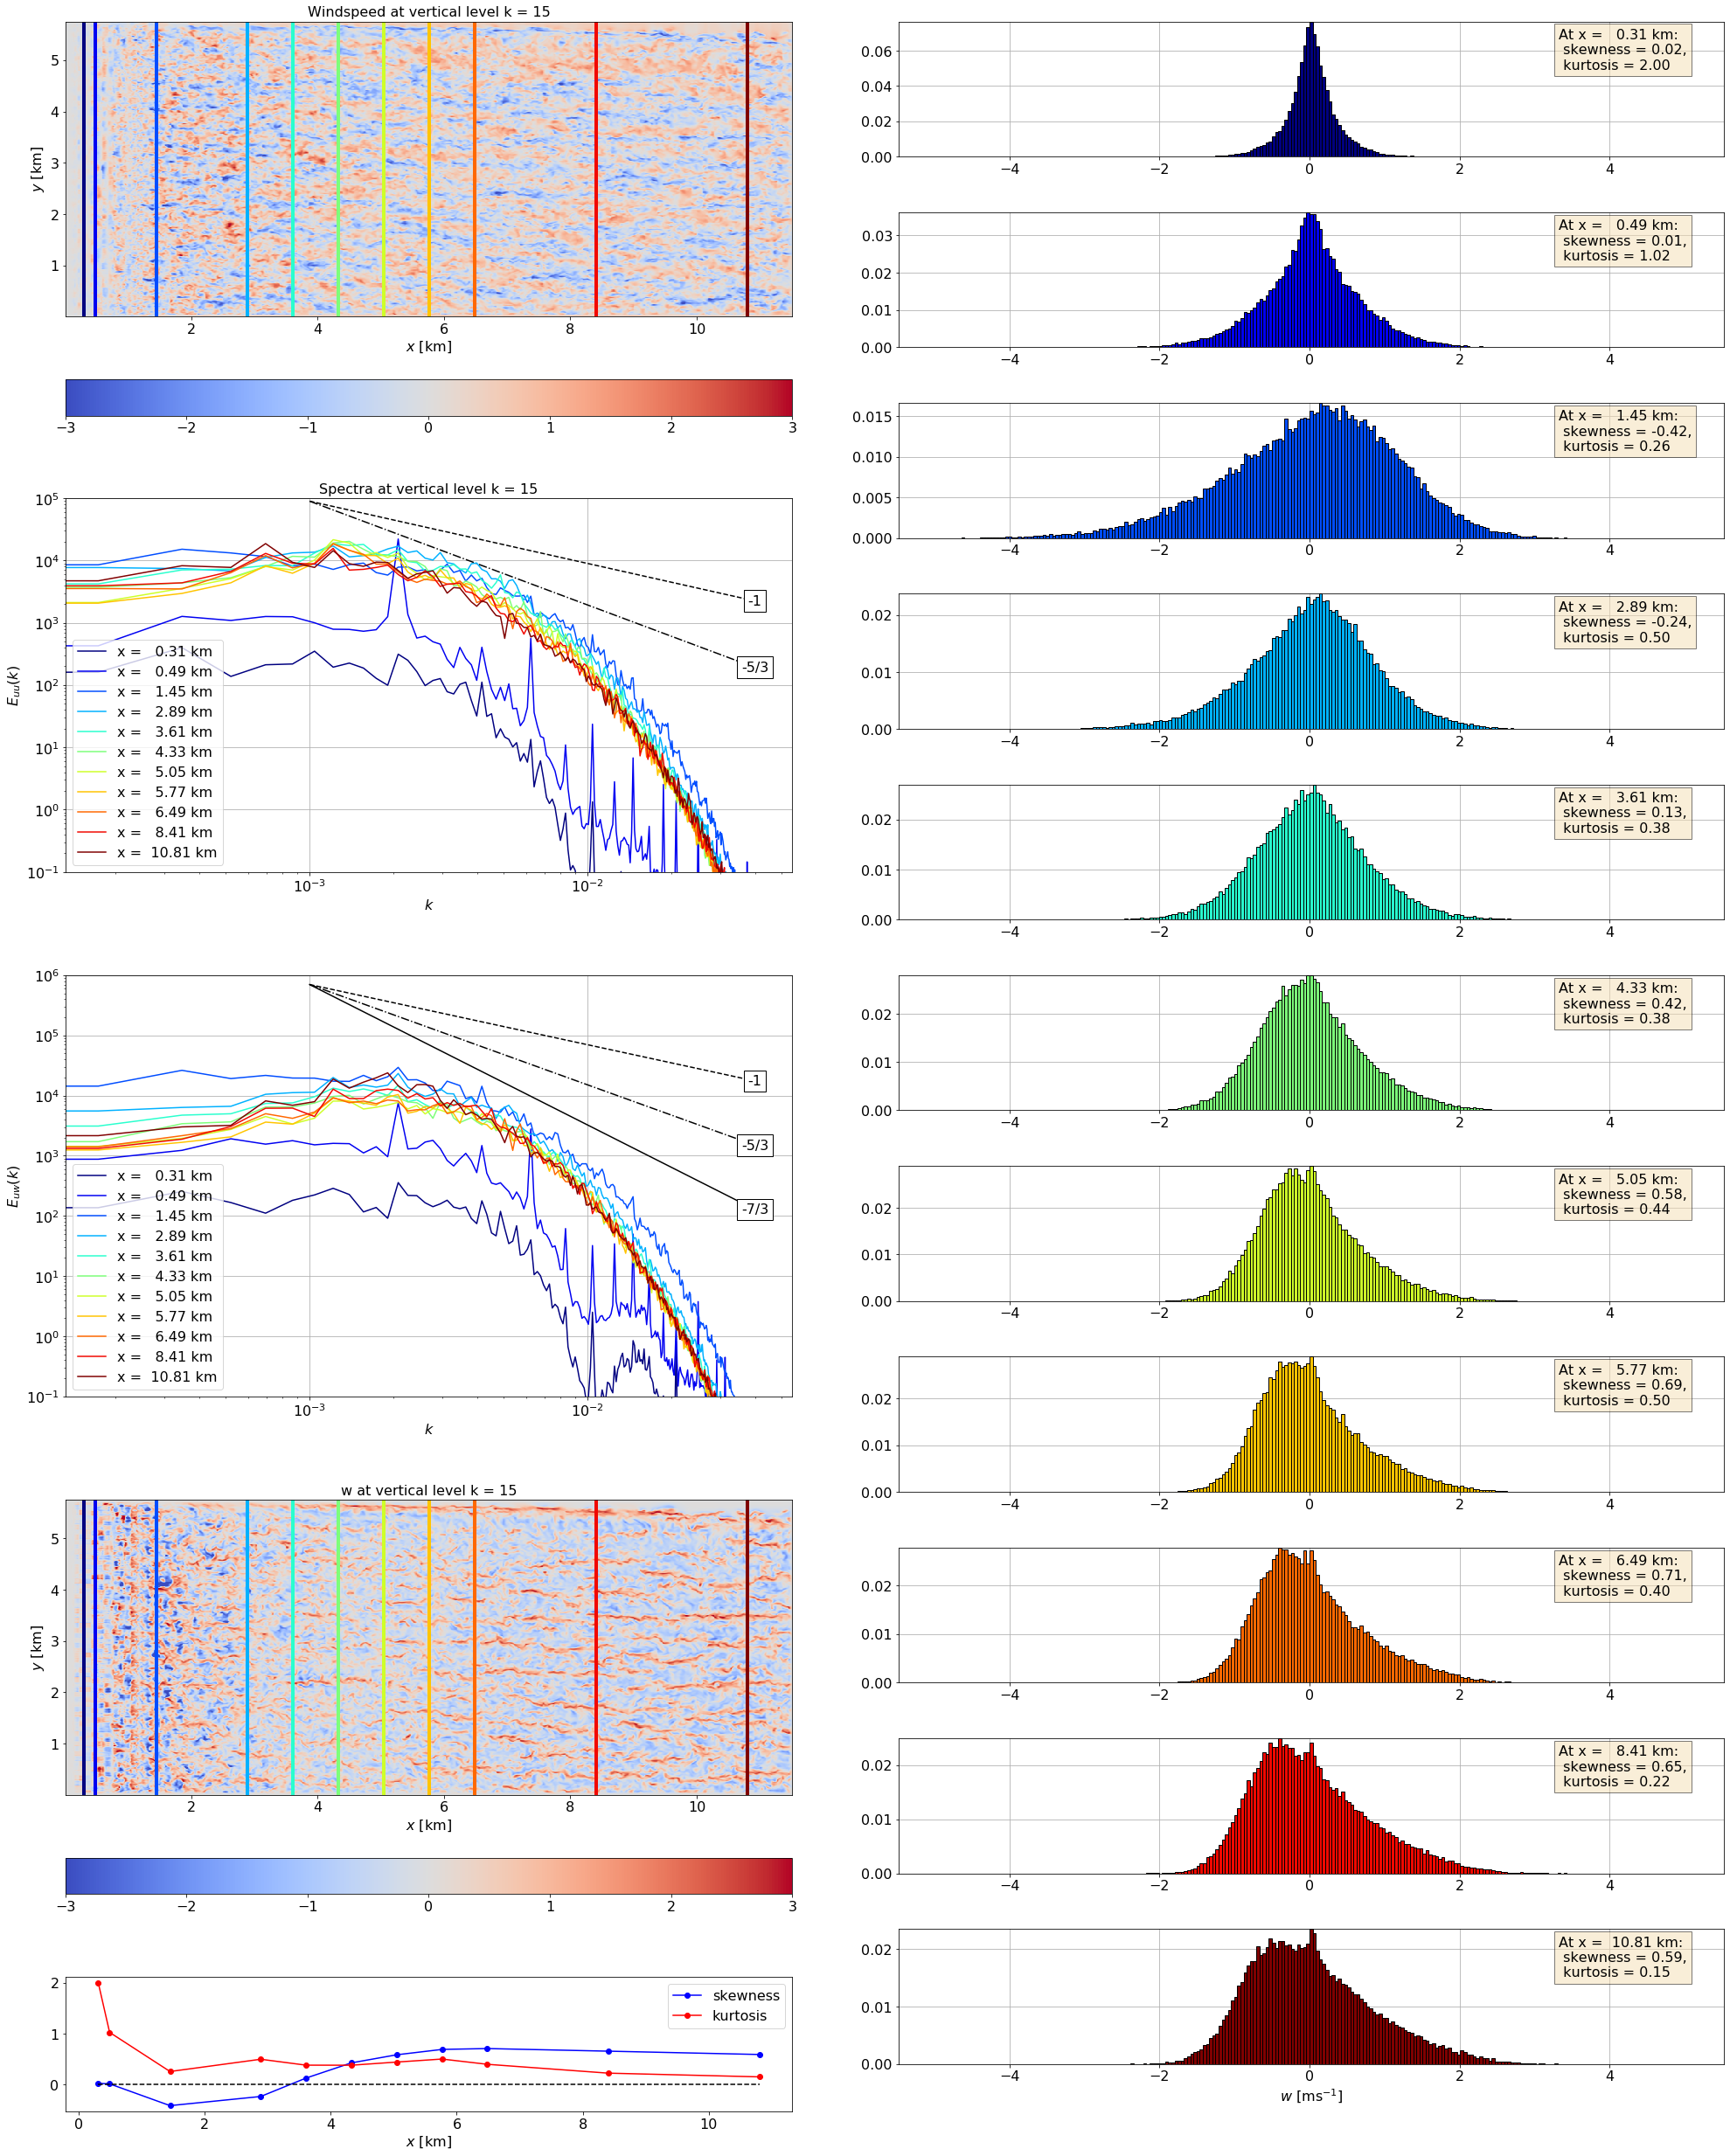

In [18]:
#%%time
from matplotlib.gridspec import GridSpec

fntSize = 16
vertLevel = spectra_ds.vert_level
datetime_to_plot = 2
figHts=4
fig = plt.figure(figsize=(34,len(iLocs)*figHts))
if model_data_type == 'wrfout': 
    spec_y_lim   = [1e-1,1e5]
    cospec_y_lim = [1e-1,1e6]
    gs=GridSpec(len(iLocs)*figHts,34)
    x_plt = ds.x.isel(nx=spectra_ds.iLocs.data)/1e3
    iLocs = spectra_ds.iLocs.data

if model_data_type == 'ts': 
    spec_y_lim = [1e-5,1e5]
    cospec_y_lim = spec_y_lim.copy()
    gs=GridSpec((len(iLocs)+1)*figHts,34)
    x_plt = ds.x.isel(nx=spectra_ds.iLocs.data,ny=0)/1e3
    iLocs = spectra_ds.iLocs.data[1::2]

bins_vector = np.zeros((stats_ds.bins.size+1))
bins_vector[:-1] = stats_ds.bins.data - (stats_ds.bins[1]-stats_ds.bins[0]).data/2.0
bins_vector[-1] = stats_ds.bins.data[-1] + (stats_ds.bins[1]-stats_ds.bins[0]).data/2.0

ax=[]
cnt_i=0
for iLoc in iLocs:
    ax.append(fig.add_subplot(gs[cnt_i*figHts:(cnt_i+1)*figHts-1,17:34]))   #The histograms
    cnt_i=cnt_i+1
numLeftColumnPlots = 6
axhgt = np.floor(((len(iLocs)+1)*figHts-1)/(numLeftColumnPlots+2)).astype(int)
ax.append(fig.add_subplot(gs[0*axhgt:2*axhgt-1,0:15]))  # The pcolormesh with overlayed lines of fetch
axpc=cnt_i
cnt_i=cnt_i+1
ax.append(fig.add_subplot(gs[2*axhgt:4*axhgt-2,0:15]))  # The spectra plot
axsp=cnt_i
cnt_i=cnt_i+1

flux_vs_fetch=False
if flux_vs_fetch:
    ax.append(fig.add_subplot(gs[4*axhgt:5*axhgt-1,0:15]))  # The TKE vs. fetch plot
    axTKE=cnt_i
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[5*axhgt:6*axhgt-1,0:15]))  # The <U'w'> vs. fetch plot
    axUw=cnt_i
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[6*axhgt:7*axhgt-1,0:15]))  # The <w'th'> vs. fetch plot
    axwth=cnt_i
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[7*axhgt:8*axhgt-1,0:15]))  # The stats plot
    axst=cnt_i
    cnt_i=cnt_i+1
else:
    ax.append(fig.add_subplot(gs[4*axhgt:6*axhgt-1,0:15]))  # The cospectra plot
    axcosp=cnt_i
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[6*axhgt+1:8*axhgt,0:15]))  # The stats plot
    axpcw=cnt_i
    cnt_i=cnt_i+1
    ax.append(fig.add_subplot(gs[8*axhgt+1:9*axhgt,0:15]))  # The stats plot
    axst=cnt_i
    cnt_i=cnt_i+1

########----  Multiple time instance histogram for each fetch-wise location in iLocs
n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))
cnt_lvl=0
cnt_i=0
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)  #Properties for text boxes
for iLoc in iLocs:
    if model_data_type == 'wrfout':
        x_str = ds['x'].isel(nx=iLoc).values/1e3
    elif model_data_type == 'ts':
        x_str = ds['x'].isel(nx=iLoc,ny=0).values/1e3
    max_histval = np.amax(stats_ds.hist_cum[cnt_lvl,cnt_i,:]/(ds.dims['datetime']*ds.dims['ny']))
    ax[cnt_i].grid(zorder=0)
    ### bins_vector[:-1] and bin_edges are equivalent
    im=ax[cnt_i].bar(bins_vector[:-1]+np.diff(bins_vector)/2, stats_ds.hist_cum[cnt_lvl,cnt_i,:]/(ds.dims['datetime']*ds.dims['ny']), 
                     width=np.diff(bins_vector),color=colors[cnt_i], ec="k", align="edge",zorder=3)
    textstr ='At x = {:6.2f} km:\n skewness = {:4.2f},\n kurtosis = {:4.2f}'.format(x_str,
                                                                                stats_ds.sk_vec[cnt_lvl,cnt_i].data,
                                                                                stats_ds.kurt_vec[cnt_lvl,cnt_i].data)
    ax[cnt_i].text(0.80, 0.95, textstr, transform=ax[cnt_i].transAxes, fontsize=16,verticalalignment='top', bbox=props)
    ax[cnt_i].set_ylim(0.0,max_histval)
    ax[cnt_i].set_ylim(0.0,max_histval)
    if(cnt_i is len(iLocs)-1):
        ax[cnt_i].set_xlabel(r'$w`$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
    cnt_i=cnt_i+1

########----  The pcolormesh and overlayed fetch lines plot
if model_data_type == 'wrfout':
    im = ax[axpc].pcolormesh(ds.x/1e3,ds.y/1e3,
                        ds['wspd'].isel(datetime=datetime_to_plot,nz=vertLevel)-ds['UMean'].isel(datetime=datetime_to_plot,nz=vertLevel),
                        zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
elif model_data_type == 'ts':
    wrfout = xr.open_dataset(sorted(glob.glob('{}wrfout_d02*'.format(modeldatapath), recursive=True))[-1])
    wrf_u = wrfout.U.isel(Time=0,bottom_top=vertLevel).data
    wrf_v = wrfout.V.isel(Time=0,bottom_top=vertLevel).data

    wrf_u = (wrf_u[:,1:] + wrf_u[:,:-1])*0.5
    wrf_v = (wrf_v[1:,:] + wrf_v[:-1,:])*0.5
    wrf_vel = (wrf_u**2 + wrf_v**2)**0.5
    im = ax[axpc].pcolormesh(wrfout.west_east*wrfout.DX/1e3, wrfout.south_north*wrfout.DY/1e3,
                    wrf_vel-np.mean(wrf_vel,axis=0),
                    zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
ax[axpc].set_title('Windspeed at vertical level k = {:d}'.format(vertLevel),fontsize=fntSize)
ax[axpc].set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axpc].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
fig.colorbar(im, ax=ax[axpc], orientation='horizontal',pad=0.15)

colors = plt.cm.jet(np.linspace(0,1,n))
cnt_i=0
for iLoc in iLocs: 
    im=ax[axpc].plot(ds.x.isel(nx=iLoc).values/1e3*np.ones(len(ds.y)),ds.y/1e3,'-',linewidth=4,color=colors[cnt_i],label='iLoc')
    cnt_i=cnt_i+1

########----  The spectra versus fetch plot
if model_data_type == 'wrfout':
    xRng = [1.0e-3,4e-2]
    y_intercept = 9e4  # starting point for ref lines
elif model_data_type == 'ts':
    xRng = [1.0e-2,4e-1]
    y_intercept = 1e4  # starting point for ref lines
slopes = np.asarray([-5/3,-1])  # reference slope list
ref_ls = ['-.','--']
slope_str = ['-5/3','-1']
yRng = reference_lines(xRng , y_intercept, slopes)
props = dict(boxstyle='square', facecolor='white', alpha=1.0)  #Properties for text boxes
for ss, slope in enumerate(slopes):
    ax[axsp].plot(xRng, yRng[:,ss], ls=ref_ls[ss], c='k') 
    ax[axsp].text(xRng[-1], yRng[-1,ss], slope_str[ss], fontsize=16, va='center', ha='center', bbox=props)
    
n = len(iLocs)
colors = plt.cm.jet(np.linspace(0,1,n))

cnt_i=0
for iLoc in iLocs:
    if model_data_type == 'wrfout':
        x_str = ds['x'].isel(nx=iLoc).values/1e3
    elif model_data_type == 'ts':
        x_str = ds['x'].isel(nx=iLoc,ny=0).values/1e3

    ax[axsp].loglog(spectra_ds.f, spectra_ds.Puuf[:,cnt_i,:].transpose(),'-',color=colors[cnt_i],label='x = {:6.2f} km'.format(x_str))
    cnt_i = cnt_i + 1
ax[axsp].grid()
ax[axsp].set_title('Spectra at vertical level k = {:d}'.format(spectra_ds.vert_level),fontsize=fntSize)

ax[axsp].set_ylim(spec_y_lim)
if model_data_type == 'wrfout':
    ax[axsp].set_ylabel(r'$E_{uu}(k)$',fontsize=fntSize)
    ax[axsp].set_xlabel(r'$k$',fontsize=fntSize)
elif model_data_type == 'ts':
    ax[axsp].set_ylabel(r'$E_{uu}(f)$',fontsize=fntSize)
    ax[axsp].set_xlabel(r'$f$',fontsize=fntSize)
ax[axsp].legend(loc='lower left',prop=dict(size=fntSize))


if flux_vs_fetch:
    ########----  The TKE, <U'w'>, and <w'th'> fetch plot
    n = len(levels)
    colors = plt.cm.gnuplot(np.linspace(0,1,n))
    cnt_k=0
    for lev in levels:
        ax[axTKE].plot(ds.x/1e3,ds['TKE'].sel(nz=lev).mean('ny').mean('datetime').transpose(),
                       color=colors[cnt_k],
                       label='z ~{:6.2f} m AGL'.format(ds['z'].isel(datetime=0,nz=lev,ny=0,nx=0).values))
        ax[axTKE].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        ax[axUw].plot(ds.x/1e3,ds['Uw'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
        ax[axUw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        ax[axwth].plot(ds.x/1e3,ds['wth'].sel(nz=lev).mean('ny').mean('datetime').transpose(),color=colors[cnt_k])
        ax[axwth].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
        cnt_k = cnt_k+1
    ax[axTKE].legend(loc='lower center',fontsize=fntSize)
else:
    ########----  The cospectra versus fetch plot
    if model_data_type == 'wrfout':
        xRng = [1.0e-3,4e-2]
        y_intercept = 7e5  # starting point for ref lines
    elif model_data_type == 'ts':
        xRng = [1.0e-2,4e-1]
        y_intercept = 3e4  # starting point for ref lines
    slopes = np.asarray([-7/3,-5/3,-1])  # reference slope list
    ref_ls = ['-','-.','--']
    slope_str = ['-7/3','-5/3','-1']
    yRng = reference_lines(xRng , y_intercept, slopes)

    props = dict(boxstyle='square', facecolor='white', alpha=1.0)  #Properties for text boxes
    for ss, slope in enumerate(slopes):
        ax[axcosp].plot(xRng, yRng[:,ss], ls=ref_ls[ss], c='k')  
        ax[axcosp].text(xRng[-1], yRng[-1,ss], slope_str[ss], fontsize=16, va='center', ha='center', bbox=props)

    n = len(iLocs)
    colors = plt.cm.jet(np.linspace(0,1,n))
    cnt_i=0
    for iLoc in iLocs:
        if model_data_type == 'wrfout':
            x_str = ds['x'].isel(nx=iLoc).values/1e3
        elif model_data_type == 'ts':
            x_str = ds['x'].isel(nx=iLoc,ny=0).values/1e3

        ax[axcosp].loglog(spectra_ds.f, spectra_ds.Puwf[:,cnt_i,:].transpose(),'-',color=colors[cnt_i],label='x = {:6.2f} km'.format(x_str))
        cnt_i = cnt_i + 1
    ax[axcosp].grid()
    #print('k-lowest = {:f}'.format(f[0]*(ds.dims['south_north']*ds.attrs['DX'])))
    #print('k-highest = {:f}'.format(f[-1]*(ds.dims['south_north']*ds.attrs['DX'])))
    #print('series length = {:d}'.format(nblock))
    #ax[axcosp].set_ylim([1e-5,1e6])
    ax[axcosp].set_ylim(cospec_y_lim)
    if model_data_type == 'wrfout':
        ax[axcosp].set_ylabel(r'$E_{uw}(k)$',fontsize=fntSize)
        ax[axcosp].set_xlabel(r'$k$',fontsize=fntSize)
    elif model_data_type == 'ts':
        ax[axcosp].set_ylabel(r'$E_{uw}(f)$',fontsize=fntSize)
        ax[axcosp].set_xlabel(r'$f$',fontsize=fntSize)
    ax[axcosp].legend(loc='lower left',prop=dict(size=fntSize))

    
########----  The pcolormesh and overlayed fetch lines plot
if model_data_type == 'wrfout':
    im = ax[axpcw].pcolormesh(ds.x/1e3,ds.y/1e3,
                        ds['w'].isel(datetime=datetime_to_plot,nz=vertLevel),
                        zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
elif model_data_type == 'ts':
    wrfout = xr.open_dataset(sorted(glob.glob('{}wrfout_d02*'.format(modeldatapath), recursive=True))[-1])
    wrf_w = wrfout.W.isel(Time=0,bottom_top_stag=vertLevel).data

    im = ax[axpcw].pcolormesh(wrfout.west_east*wrfout.DX/1e3, wrfout.south_north*wrfout.DY/1e3,
                    wrf_w,
                    zorder=1,cmap=plt.cm.coolwarm,vmin=-3, vmax=3)
ax[axpcw].set_title('w at vertical level k = {:d}'.format(vertLevel),fontsize=fntSize)
ax[axpcw].set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axpcw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
fig.colorbar(im, ax=ax[axpcw], orientation='horizontal',pad=0.15)

colors = plt.cm.jet(np.linspace(0,1,n))
cnt_i=0
for iLoc in iLocs: 
    im=ax[axpcw].plot(ds.x.isel(nx=iLoc).values/1e3*np.ones(len(ds.y)),ds.y/1e3,'-',linewidth=4,color=colors[cnt_i],label='iLoc')
    cnt_i=cnt_i+1
    
########----  The stats versus fetch plot
ax[axst].plot(x_plt,stats_ds.sk_vec[cnt_lvl,:],'o-',color='b',label='skewness')
ax[axst].plot(x_plt,stats_ds.kurt_vec[cnt_lvl,:],'o-',color='r',label='kurtosis')
ax[axst].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
ax[axst].legend(loc='upper right',fontsize=fntSize)
ax[axst].plot(x_plt,np.zeros(x_plt.shape),'--',color='k',label='skewness = 0 (symmetric), kurtosis = 0 (normal)')

if save_figs:
    print(output_figure)
    fig.savefig(output_figure,dpi=200)
plt.show()
##Past-timing
#CPU times: user 3.9 s, sys: 7.3 s, total: 11.2 s
#Wall time: 2min 4s  

# Create TKE, momentum flux, and sensible heat flux versus fetch figure

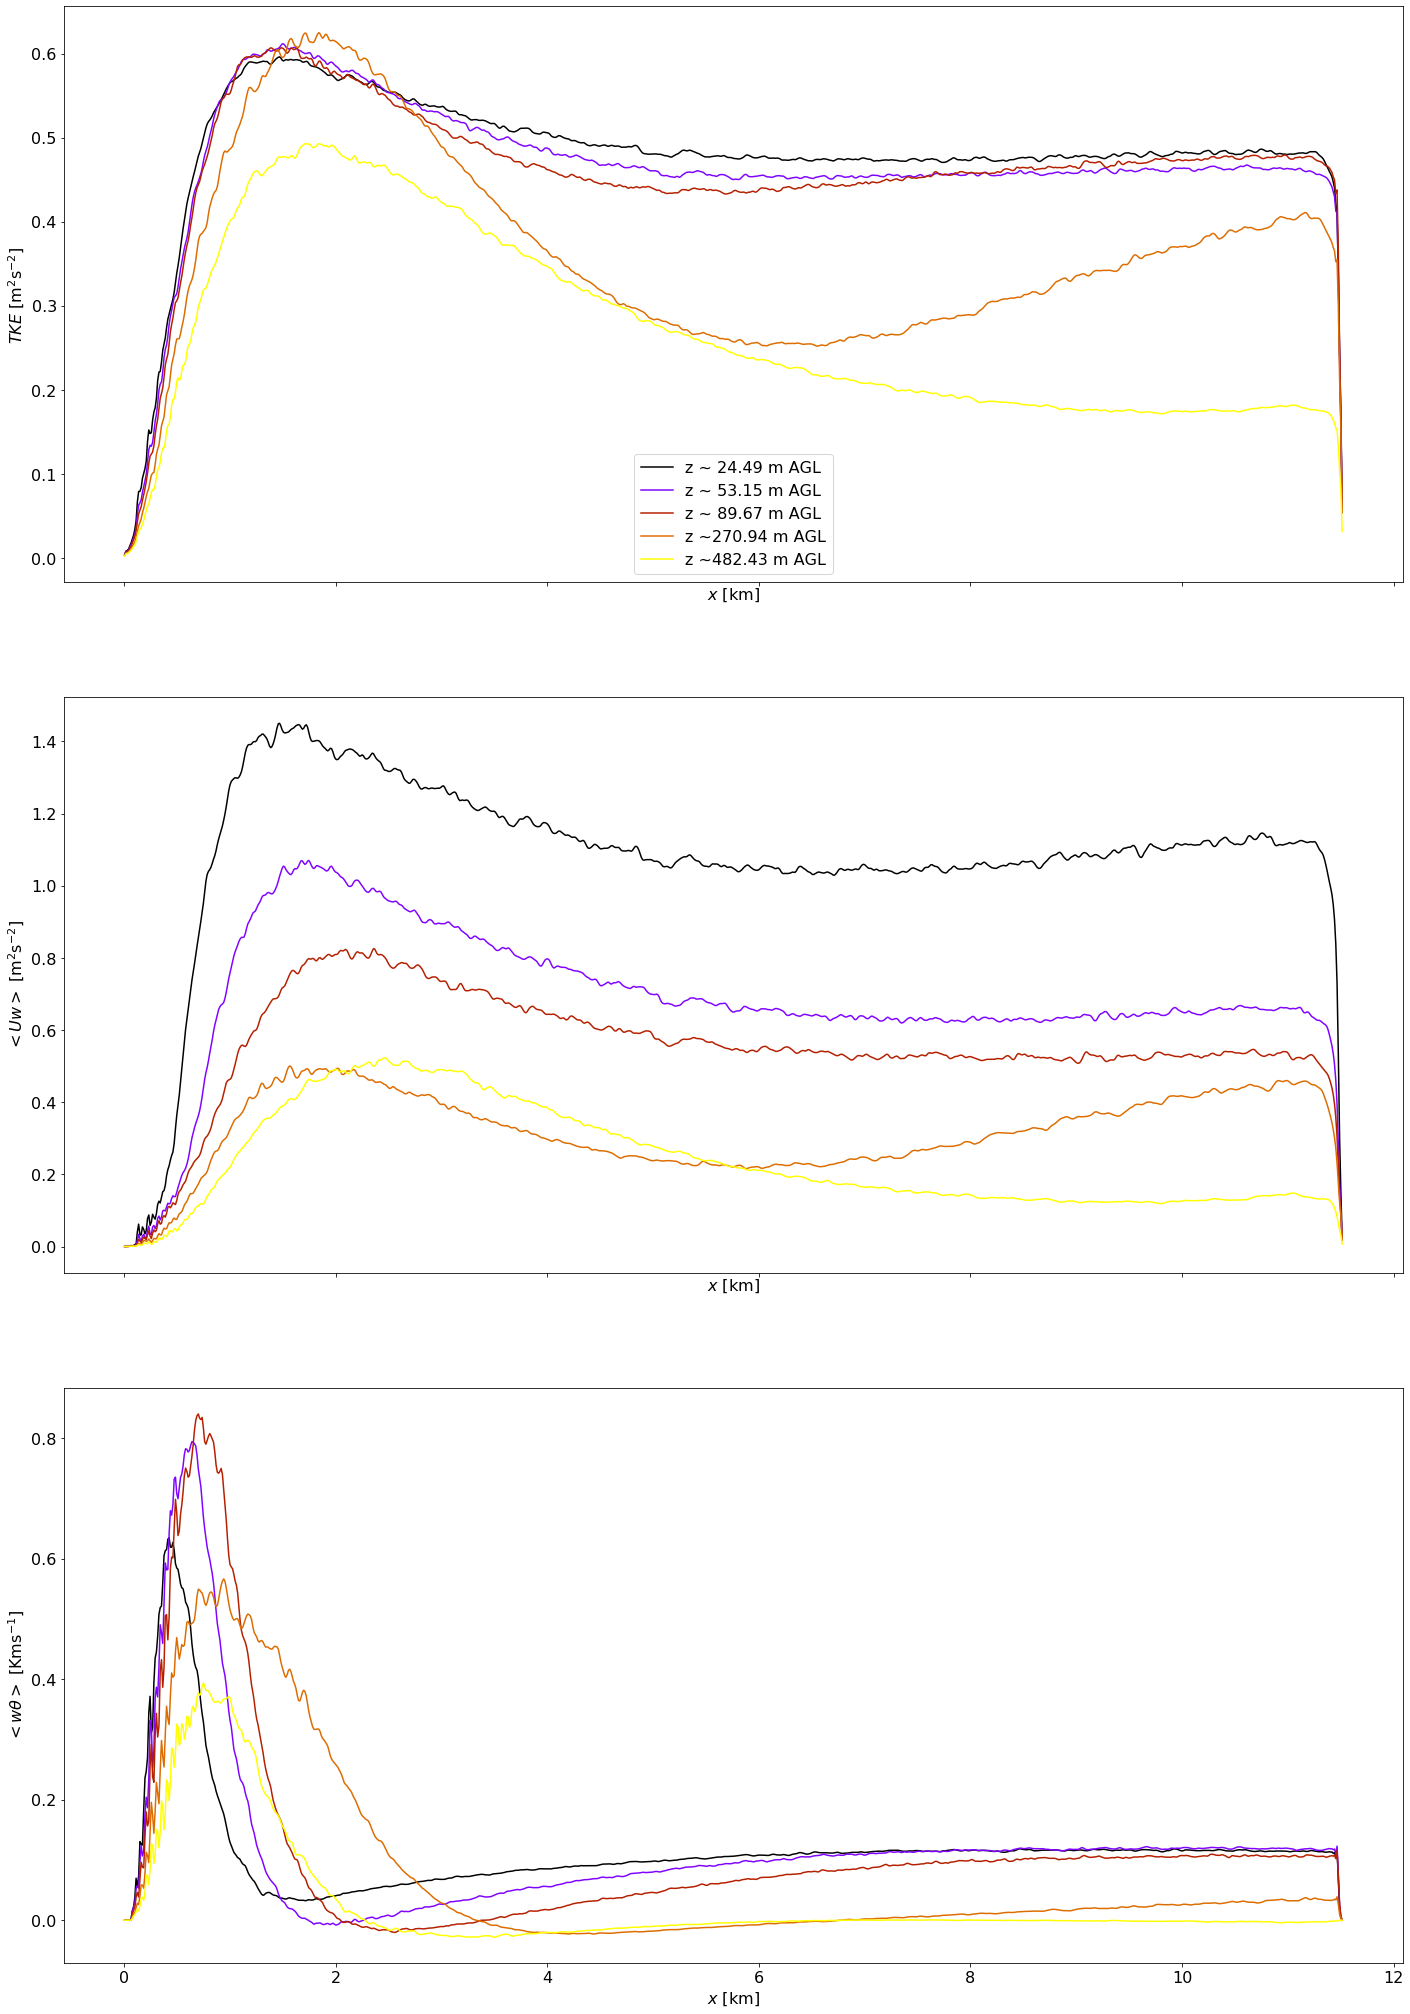

In [20]:
fig, ax = plt.subplots(3,1, figsize=(24, 36), sharex=True)
axTKE=0
axUw=1
axwth=2
########----  The TKE, <U'w'>, and <w'th'> fetch plot
n = len(levels)
colors = plt.cm.gnuplot(np.linspace(0,1,n))
cnt_k=0


if model_data_type == 'wrfout':
    x_plt = ds.x/1e3
elif model_data_type == 'ts':
    x_plt = ds.x.isel(ny=0)/1e3
    
for cnt_k,lev in enumerate(levels):
    ax[axTKE].plot(x_plt,ds['TKE'].sel(nz=lev).mean('datetime').mean('ny').transpose(),
                   color=colors[cnt_k],
                   label='z ~{:6.2f} m AGL'.format(ds['z'].isel(datetime=0,nz=lev,ny=0,nx=0).values))
    ax[axTKE].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axTKE].set_ylabel(r'$TKE$ $[\mathrm{m^2 s^{-2}}]$',fontsize=fntSize)
    ax[axUw].plot(x_plt,ds['Uw'].sel(nz=lev).mean('datetime').mean('ny').transpose(),color=colors[cnt_k])
    ax[axUw].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axUw].set_ylabel(r'$<Uw>$ $[\mathrm{m^2 s^{-2}}]$',fontsize=fntSize)
    ax[axwth].plot(x_plt,ds['wth'].sel(nz=lev).mean('datetime').mean('ny').transpose(),color=colors[cnt_k])
    ax[axwth].set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    ax[axwth].set_ylabel(r'$<w\theta>$ $[\mathrm{Km s^{-1}}]$',fontsize=fntSize)
    ax[axTKE].legend(loc='lower center',fontsize=fntSize)
if save_figs:
    print(output_fetch)
    fig.savefig(output_fetch,dpi=200)

# Compare microscale domains mean-profiles to observations

In [21]:
if compare_to_obs:
    df = pd.read_csv(TTUdata, parse_dates=True, index_col='datetime')
    # Calculate wind speed and direction
    df['wspd'], df['wdir'] = calc_wind(df)
    # Calculate potential temperature
    df['theta'] = theta(df['T'],df['p'])
    df30 = df.pivot(columns='height',values=['u','v','w','wspd','wdir','theta']).resample('30min').mean().stack()
    df30.reset_index(inplace=True)
    df30.set_index(['datetime'],inplace=True)
    obs_legStrs = []
    mod_legStrs = []
    datetimeStrs = []
    modelHours = [18,19]  #commensurate with model_file_filter
    for modelHour in modelHours:
        obs_legStrs.append('Obs-{:d}Z'.format(modelHour))
        mod_legStrs.append('Mod-{:d}Z'.format(modelHour))
        datetimeStrs.append('2013-11-08 {:2d}:00:00.00'.format(modelHour))
    print(obs_legStrs)
    print(mod_legStrs)
    print(datetimeStrs)

['Obs-18Z', 'Obs-19Z']
['Mod-18Z', 'Mod-19Z']
['2013-11-08 18:00:00.00', '2013-11-08 19:00:00.00']


### tslist needs to be parsed by x and y (instead of z) due to time it takes to read all dask chunks

In [22]:
if compare_to_obs:
    if model_data_type == 'ts': 
        del ds
        ds=xr.open_mfdataset(modelprocessedname,concat_dim='datetime',combine='nested',chunks={'nx': 10, 'ny': 10})

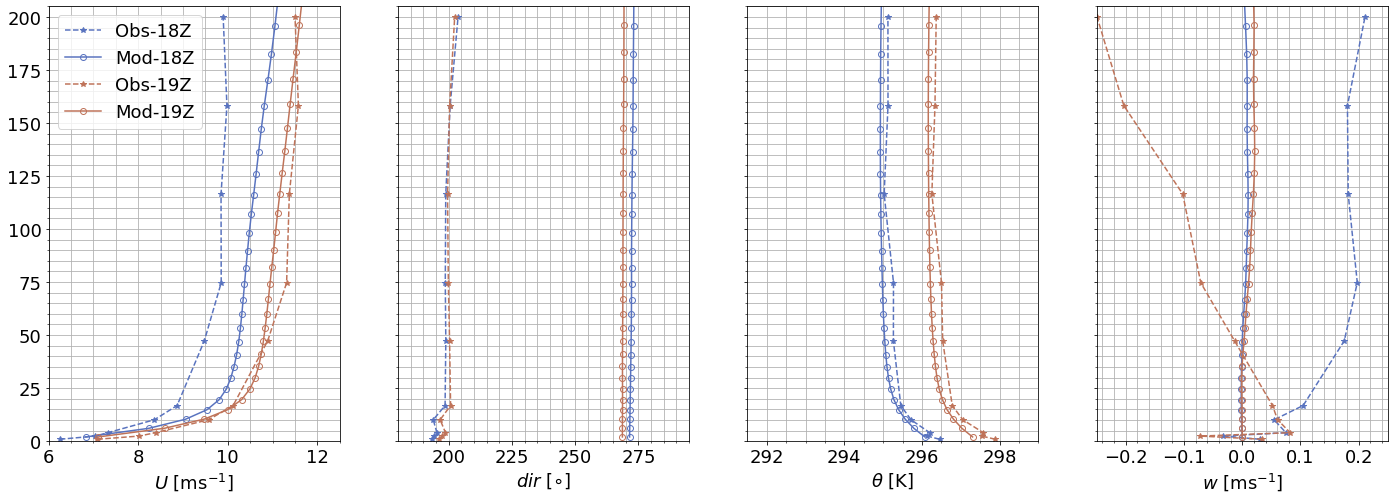

In [23]:
if compare_to_obs:
    fntSize=18
    plt.rcParams['xtick.labelsize']=fntSize
    plt.rcParams['ytick.labelsize']=fntSize
    numPlotsX = 1
    numPlotsY = 4
    colors = []
    #colors.append([0.25,0.25,0.75])
    colors.append([0.35,0.45,0.75])
    colors.append([0.75,0.45,0.35])
    fig,ax = plt.subplots(numPlotsX,numPlotsY,sharey=True,sharex=False,figsize=(24,8))
    iLoc = iLocs[7]
    # plot-windspeed
    for it in range(len(modelHours)): 
        if 'datetime' in ds['z'].dims:
            if model_data_type == 'wrfout':   zValues = ds['z'].sel(datetime=datetimeStrs[it],ny=0,nx=iLoc)
            elif model_data_type == 'ts': zValues = ds['z'].sel(ny=0,nx=iLoc).sel(datetime=datetimeStrs[it]).isel(datetime=0)
        else:
            zValues = ds['z']
        # plot-windspeed
        im = ax[0].plot(df30['wspd'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
        if model_data_type == 'wrfout':
            im = ax[0].plot(ds['UMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues,
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        elif model_data_type == 'ts':
            im = ax[0].plot(ds['UMean'].sel(nx=iLoc,ny=0,nz=range(ds.dims['nz']-1)).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues[:-1],
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        # plot-wind_dir.
        im = ax[1].plot(df30['wdir'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
        if model_data_type == 'wrfout':
            im = ax[1].plot(ds['UdirMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues,
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        elif model_data_type == 'ts':
            im = ax[1].plot(ds['UdirMean'].sel(nx=iLoc,ny=0,nz=range(ds.dims['nz']-1)).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues[:-1],
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        # plot-theta
        im = ax[2].plot(df30['theta'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
        if model_data_type == 'wrfout':
            im = ax[2].plot(ds['thetaMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues,
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        elif model_data_type == 'ts':
            im = ax[2].plot(ds['thetaMean'].sel(nx=iLoc,ny=0,nz=range(ds.dims['nz']-1)).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues[:-1],
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        # plot-w
        im = ax[3].plot(df30['w'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
        if model_data_type == 'wrfout':
            im = ax[3].plot(ds['wMean'].sel(nx=iLoc,nz=range(ds.dims['nz'])).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues,
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
        elif model_data_type == 'ts':        
            im = ax[3].plot(ds['wMean'].sel(nx=iLoc,ny=0,nz=range(ds.dims['nz']-1)).resample({'datetime':'30min'}).mean(dim='datetime').sel(datetime=datetimeStrs[it]),
                            zValues[:-1],
                            'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    #ax[0].set_ylim([0,1700])
    #ax[0].set_xlim([5,18.5])

    ax[0].set_ylim([0,205])
    ax[0].set_xlim([6,12.5])
    ax[1].set_xlim([180,295])
    ax[2].set_xlim([291.5,299])
    ax[3].set_xlim([-0.25,0.25])

    ax[0].legend(fontsize=fntSize)
    ax[0].set_xlabel(r'$U$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
    ax[0].minorticks_on()
    ax[0].grid(which='both')

    ax[1].set_xlabel(r'$dir$ $[\mathrm{\circ}]$',fontsize=fntSize)
    ax[1].minorticks_on()
    ax[1].grid(which='both')

    ax[2].set_xlabel(r'$\theta$ $[\mathrm{K}]$',fontsize=fntSize)
    ax[2].minorticks_on()
    ax[2].grid(which='both')

    ax[3].set_xlabel(r'$w$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
    ax[3].minorticks_on()
    ax[3].grid(which='both')
    if save_figs:
        print(output_obscomp)
        fig.savefig(output_obscomp,dpi=200)